In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display

from typing import List, Tuple

import yfinance as yf

In [19]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

In [20]:
TREASURY_BILL_RATE = 0.11
TRADING_DAYS_PER_YEAR = 250

In [21]:
class Asset:
    pass


def get_log_period_returns(price_history: pd.DataFrame):
    close = price_history['Close'].values
    return np.log(close[1:] / close[:-1]).reshape(-1, 1)


class Asset:
    def __init__(self, name: str, daily_price_history: pd.DataFrame):
        self.name = name
        self.daily_returns = get_log_period_returns(daily_price_history)
        self.expected_daily_return = np.mean(self.daily_returns)

    @property
    def expected_return(self):
        return TRADING_DAYS_PER_YEAR * self.expected_daily_return

    def __repr__(self):
        return f'<Asset name={self.name}, expected return={self.expected_return}>'

    def covariance_matrix(assets: Tuple[Asset]):
        product_expectation = np.zeros((len(assets), len(assets)))
        for i in range(len(assets)):
            for j in range(len(assets)):
                if i == j:
                    product_expectation[i][j] = np.mean(
                        assets[i].daily_returns * assets[j].daily_returns)
                else:
                    product_expectation[i][j] = np.mean(
                        assets[i].daily_returns @ assets[j].daily_returns.T)

        product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

        expected_returns = np.array(
            [asset.expected_return for asset in assets]).reshape(-1, 1)
        product_of_expectations = expected_returns @ expected_returns.T

        return product_expectation - product_of_expectations


In [22]:
def random_weights(weight_count):
    weights = np.random.random((weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
    def __init__(self, assets: Tuple[Asset]):
        self.assets = assets
        self.asset_expected_returns = np.array(
            [asset.expected_return for asset in assets]).reshape(-1, 1)
        self.covariance_matrix = Asset.covariance_matrix(assets)
        self.weights = random_weights(len(assets))

    def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
        res = minimize(
            lambda w: self._variance(
                w) - risk_tolerance * self._expected_return(w),
            random_weights(self.weights.size),
            constraints=[
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            ],
            bounds=[(0., 1.) for i in range(self.weights.size)]
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def optimize_with_risk_tolerance(self, risk_tolerance: float):
        assert risk_tolerance >= 0.
        return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)

    def optimize_with_expected_return(self, expected_portfolio_return: float):
        res = minimize(
            lambda w: self._variance(w),
            random_weights(self.weights.size),
            constraints=[
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
                {'type': 'eq', 'fun': lambda w: self._expected_return(
                    w) - expected_portfolio_return},
            ],
            bounds=[(0., 1.) for i in range(self.weights.size)]
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def optimize_sharpe_ratio(self):
        res = minimize(
            lambda w: -(self._expected_return(w) -
                        TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
            random_weights(self.weights.size),
            constraints=[
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            ],
            bounds=[(0., 1.) for i in range(self.weights.size)]
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def _expected_return(self, w):
        return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]

    def _variance(self, w):
        return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

    @property
    def expected_return(self):
        return self._expected_return(self.weights)

    @property
    def variance(self):
        return self._variance(self.weights)

    def __repr__(self):
        return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'


In [23]:
def yf_retrieve_data(tickers: List[str]):
    dataframes = []

    for ticker_name in tickers:
        ticker = yf.Ticker(ticker_name)
        history = ticker.history(period='10y')

        if history.isnull().any(axis=1).iloc[0]: 
            history = history.iloc[1:]

        assert not history.isnull().any(
            axis=None), f'history has NaNs in {ticker_name}'
        dataframes.append(history)

    return dataframes

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

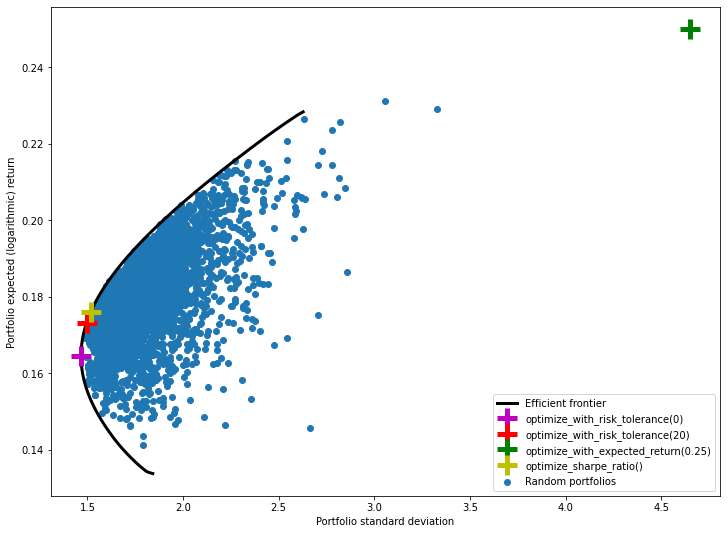

In [25]:
stocks = ['AAPL', 'AMZN', 'GOOG', 'BRK-B', 'JNJ', 'JPM']
daily_dataframes = yf_retrieve_data(stocks)
assets = tuple([Asset(name, daily_df)
                for name, daily_df in zip(stocks, daily_dataframes)])

X = []
y = []

for i in range(3000):
    print(i)
    portfolio = Portfolio(assets)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

X = []
y = []
for rt in np.linspace(-300, 200, 1000):
    print(rt)
    portfolio.unsafe_optimize_with_risk_tolerance(rt)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+',
         markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(20)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+',
         markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.25)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+',
         markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.25)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+',
         markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()


In [26]:
pd.options.display.float_format = "{:,.5f}".format

portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(20)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(0.25)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
    pd.DataFrame(
        list(
            zip(
                [asset.name for asset in portfolio.assets],
                riskless_weights,
                weights_risk_tolerance,
                weights_return,
                weights_sharpe,
            )
        ),
        columns=[
            'asset',
            'optimize_with_risk_tolerance(0)',
            'optimize_with_risk_tolerance(20)',
            'optimize_with_expected_return(0.25)',
            'optimize_sharpe_ratio()',
        ],
    )
)

,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(20),optimize_with_expected_return(0.25),optimize_sharpe_ratio()
0,AAPL,0.10859,0.13673,0.02392,0.14542
1,AMZN,0.09481,0.13283,0.97608,0.14440
2,GOOG,0.13381,0.15938,0.00000,0.16675
3,BRK-B,0.25254,0.22444,0.00000,0.21685
4,JNJ,0.28869,0.24342,0.00000,0.22908
5,JPM,0.12157,0.10320,0.00000,0.09750
